In [1]:
# for dealing with data
import pandas as pd
import numpy as np
import random


# for visualization
from matplotlib import pyplot as plt
import seaborn as sns


# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV


# Mathematics library
import math


# for statisticals tools 
from scipy import stats
import scipy as sci
from scipy.spatial.distance import minkowski


# helpers file
from preprocessing_helper import *
from sampling_helper import *
from metrics_helper import *


# we set the dimensions of the plots
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


# Preprocessing

### Dataset import

In [3]:
# we import the dataset using pandas

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Project2/GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False)

In [4]:
# we visualize the first ten rows of our dataframe
df.head(10)

,Unnamed: 0,Kmer,y_1,y_2,y_3,y_4,y_5,y_6,zC_1,zC_2,zC_3,zC_4,zC_5,zC_6,x_1,x_2,x_3,x_4,x_5,x_6,zW_1,zW_2,zW_3,zW_4,zW_5,zW_6,y_7,y_8,y_9,y_10,y_11,y_12,zC_7,zC_8,zC_9,zC_10,zC_11,zC_12,x_7,x_8,...,x_70,x_71,x_72,zW_67,zW_68,zW_69,zW_70,zW_71,zW_72,y_73,y_74,y_75,y_76,y_77,y_78,zC_73,zC_74,zC_75,zC_76,zC_77,zC_78,x_73,x_74,x_75,x_76,x_77,x_78,zW_73,zW_74,zW_75,zW_76,zW_77,zW_78,y_79,y_80,y_81,y_82,y_83,y_84,relKa
0,0,AATGATTAATTACC,0.593697,-1.092779,0.309117,0.133525,0.023403,-0.157348,1.177586,-2.166888,-1.059702,-0.986852,9.851130,-1.990198,-0.398346,0.089837,3.357047,-0.769275,-0.221956,3.386346,0.605164,-4.442468,-2.825918,0.281830,9.129749,-1.237129,0.167000,-1.267301,0.183102,0.141690,0.025378,0.080681,1.958107,-2.755203,-1.608669,-0.641613,9.935603,-1.641385,0.009468,-0.179413,...,-0.219001,-0.545648,3.323891,0.752496,-3.620260,-2.373654,-0.318634,9.522320,-1.373931,0.322805,-0.900553,0.124381,0.036043,0.022354,0.004046,2.020696,-4.257512,-2.142878,0.010588,9.566650,-0.941402,-0.131415,0.153189,3.356950,0.438937,-0.894560,3.707160,2.591673,-3.422281,-1.331358,-0.674709,10.019444,-1.012806,-0.790300,-0.112492,0.118705,0.237596,-0.009713,0.267886,1.000000
1,1,GGTAATTAATCATT,0.790300,-0.112492,0.118705,-0.237596,-0.009713,0.267886,2.591673,-3.422281,-1.331358,-0.674709,10.019444,-1.012806,0.131415,0.153189,3.356950,-0.438937,-0.894560,3.707160,2.020696,-4.257512,-2.142878,0.010588,9.566650,-0.941402,-0.322805,-0.900553,0.124381,-0.036043,0.022354,0.004046,0.752496,-3.620260,-2.373654,-0.318634,9.522320,-1.373931,0.092423,-0.159535,...,-0.117570,-0.826970,3.284579,1.958107,-2.755203,-1.608669,-0.641613,9.935603,-1.641385,-0.167000,-1.267301,0.183102,-0.141690,0.025378,0.080681,0.605164,-4.442468,-2.825918,0.281830,9.129749,-1.237129,0.398346,0.089837,3.357047,0.769275,-0.221956,3.386346,1.177586,-2.166888,-1.059702,-0.986852,9.851130,-1.990198,-0.593697,-1.092779,0.309117,-0.133525,0.023403,-0.157348,1.000000
2,2,AATGATTAATTACT,0.593690,-1.092780,0.309116,0.133525,0.023403,-0.157348,1.177587,-2.166890,-1.059703,-0.986851,9.851129,-1.990198,-0.398346,0.089837,3.357047,-0.769275,-0.221958,3.386346,0.605174,-4.442467,-2.825916,0.281830,9.129752,-1.237126,0.166994,-1.267297,0.183101,0.141690,0.025378,0.080682,1.958105,-2.755201,-1.608675,-0.641611,9.935602,-1.641385,0.009466,-0.179412,...,-0.197861,-0.587698,3.365527,1.077618,-3.502014,-2.362643,-0.283750,9.607518,-1.279651,0.118214,-0.940085,0.118129,0.068205,0.010715,0.111194,1.687236,-4.636734,-2.726127,0.248499,9.282680,-0.900859,0.372109,0.309957,3.365526,0.952859,-0.630216,3.537972,2.137980,-2.777053,-1.371144,-0.839165,10.065669,-1.499679,-0.826872,-1.141872,0.500342,-0.143809,0.043456,0.095141,0.968830
3,3,AGTAATTAATCATT,0.826872,-1.141872,0.500342,0.143809,0.043456,0.095141,2.137980,-2.777053,-1.371144,-0.839165,10.065669,-1.499679,-0.372109,0.309957,3.365526,-0.952859,-0.630216,3.537972,1.687236,-4.636734,-2.726127,0.248499,9.282680,-0.900859,-0.118214,-0.940085,0.118129,-0.068205,0.010715,0.111194,1.077618,-3.502014,-2.362643,-0.283750,9.607518,-1.279651,0.128618,-0.194635,...,-0.117566,-0.826970,3.284579,1.958105,-2.755201,-1.608675,-0.641611,9.935602,-1.641385,-0.166994,-1.267297,0.183101,-0.141690,0.025378,0.080682,0.605174,-4.442467,-2.825916,0.281830,9.129752,-1.237126,0.398346,0.089837,3.357047,0.769275,-0.221958,3.386346,1.177587,-2.166890,-1.059703,-0.986851,9.851129,-1.990198,-0.593690,-1.092780,0.309116,-0.133525,0.023403,-0.157348,0.968830
4,4,AGGTAATTAATCAT,1.260372,-0.870861,0.397555,0.124897,0.053255,0.213696,1.977567,-2.851909,-1.221460,-0.880962,10.025845,-1.642795,-0.266185,0.204191,3.216330,-0.681036,-0.476294,3.442315,0.642092,-4.266000,-2.627636,0.016634,9.208967,-1.301511,0.786770,-0.992287,0.103240,-0.074456,0.003321,0.194351,2.534342,-3.680673,-1.991732,-0.274260,9.890460,-0.813813,0.070630,0.340495,...,-0.793210,0.012080,3.301216,0.818175,-4.351474,-3.092293,0.311545,9.107817,-1.107212,-0.423566,-0.595845,0.257652,0.130952,0.037417,0.075636,1.

The dataframe has 321 columns, the column "Unnamed:0" corresponds clearly to the indices of our dataframe so it doesn't carry any additional information (we will drop it soon), the column "Kmer" contains the DNA sequences corresponding to each datapoint (a protein). The column "relKa" represents the probability that the protein is a binding site or not and it is a number from zero to one coming from experiments. Finally, the other columns are mechanical properties of the protein.

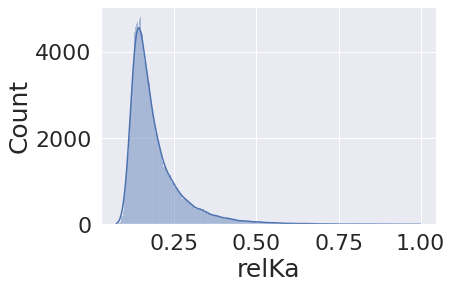

In [5]:
# we plot the distribution of the target label

sns.set(font_scale=2)
p = sns.histplot(data = df.relKa, kde=True)
p.set_xlabel("relKa", fontsize = 25) ## we want the labels to be big because we will use this plots in the report
p.set_ylabel("Count", fontsize = 25)
plt.show()

As we can observe the distribution is very skewed. Indeed, there are very few datapoints with a relKa bigger than 0.7. This makes our task quite hard since it is hard for a machine learning model to learn in the range of relKas between 0.7 and 1 because we have few datapoints in that range.

In [6]:
df.drop(columns = 'Unnamed: 0', inplace = True) # we drop the column with the indices
df.drop(columns = 'Kmer', inplace = True) # we drop the column with DNA sequences

We also tried to encode the DNA sequence instead of dropping with one hot encoding or sequential encoding but the final results were slightly worse.

### Splitting the dataset

In [7]:
# we divide our dataset in y labels and x label

y = df['relKa'].to_numpy()
x = df.loc[:, df.columns != 'relKa'].to_numpy()

In [8]:
# we split the x and y in x_0, x_1, y_0, y_1 where x_0 are all the features of the points with relka between 0 and 0.7, 
# x_1 are all the features of the points with relka between 0.7 and 1 and y_0,y_1 are the relKa corresponding to the two groups
# respectively


x_1,y_1,x_0,y_0 = split_importance(x,y)

In [9]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.3, random_state=42) # fede aveva messo 0.4

x_train = np.concatenate((x_1_train, x_0_train))
y_train = np.concatenate((y_1_train, y_0_train))
x_test = np.concatenate((x_1_test, x_0_test))
y_test = np.concatenate((y_1_test, y_0_test))

### Outliers remotion

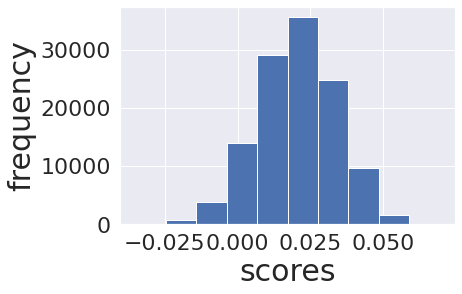

The indecision percentage around 0.02 is 0.47895415640755074
The percentage of outliers detected is 0.06591796057149557


In [10]:
# we apply the algorithm for outliers remotion
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)

# we check that the algorithm is working properly
check_Isolation_Forests(contamination, outliers_indices, y_train)

# we plot the distribution of the scores
check_boundary_decision(scores, 0.02, verbose=1)

In [11]:
# we drop the outliers
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

### Features scaling

In [12]:
# we create a scaler
sc = StandardScaler()

# we fit and scale on the train (we work with the mean and the std of the train)
x_train = sc.fit_transform(x_train)

# we use the same scaler (same mean and same std to scale the validation and the test set)
x_test = sc.transform(x_test)

### Create the labels

In [13]:
## Now we transform the RelKa in labels:

# The relKa values belonging to [0.7,1] will be labelled as 1
# The relKa values belonging to [0,0.7] will be labelled as 0

y_train = split_RelKa(y_train, 0.7)
y_test = split_RelKa(y_test, 0.7)

### Sampling

In [14]:
x_train, y_train = smote_sf_classification(x_train, y_train)

Output streaming troncato alle ultime 5000 righe.
Starting  6130  iteration
Starting  6131  iteration
Starting  6132  iteration
Starting  6133  iteration
Starting  6134  iteration
Starting  6135  iteration
Starting  6136  iteration
Starting  6137  iteration
Starting  6138  iteration
Starting  6139  iteration
Starting  6140  iteration
Starting  6141  iteration
Starting  6142  iteration
Starting  6143  iteration
Starting  6144  iteration
Starting  6145  iteration
Starting  6146  iteration
Starting  6147  iteration
Starting  6148  iteration
Starting  6149  iteration
Starting  6150  iteration
Starting  6151  iteration
Starting  6152  iteration
Starting  6153  iteration
Starting  6154  iteration
Starting  6155  iteration
Starting  6156  iteration
Starting  6157  iteration
Starting  6158  iteration
Starting  6159  iteration
Starting  6160  iteration
Starting  6161  iteration
Starting  6162  iteration
Starting  6163  iteration
Starting  6164  iteration
Starting  6165  iteration
Starting  6166

### Training

In [18]:
from sklearn.metrics import confusion_matrix
def return_accuracy(y_test, y_pred, verbose=1):
    """
    This function computes the standard accuracy of a prediction
    @param y_test: the true labels
    @param y_pred: the predicted labels
    @param verbose: verbose parameter
    @return: the accuracy of the prediction
    """
    # we compute the confusion matrix
    C = confusion_matrix(y_test, y_pred)
    # we compute the accuracy
    accuracy = np.trace(C) / len(y_test)
    if verbose == 1:
        # print all the elements of the matrix and the accuracies on the two classes
        print("The number of true negatives is:", C[0, 0])
        print("The number of false negatives is:", C[1, 0])
        print("The number of false positives is:", C[0, 1])
        print("The number of true positives is:", C[1, 1])
        print("The accuracy is:", accuracy)
        print("The accuracy on the 1's is ", 1 / np.sum(y_test == 1) * (np.sum(y_test == 1) - C[1, 0]))
        print("The accuracy on the 0's is ", 1 / np.sum(y_test == 0) * (np.sum(y_test == 0) - C[0, 1]))
    return accuracy

In [19]:
clf = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, min_samples_leaf = 1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 50814
The number of false negatives is: 8
The number of false positives is: 263
The number of true positives is: 90
The accuracy is: 0.994704445530044
The accuracy on the 1's is  0.9183673469387754
The accuracy on the 0's is  0.9948509113691094


0.994704445530044

####Cross Validation

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 35, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [23]:
# we create the model
model = RandomForestClassifier()

# we apply randomized search to select the best hyperparameters using cross validation
clf = RandomizedSearchCV(estimator = model,
                         param_distributions = random_grid,
                         n_iter=10,
                         scoring = 'average_precision',
                         verbose=10)
# we fit to produce the new results
clf.fit(x_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900
[CV 1/5; 1/10] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=1.000 total time= 1.4min
[CV 2/5; 1/10] START bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900
[CV 2/5; 1/10] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=0.999 total time= 1.4min
[CV 3/5; 1/10] START bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900
[CV 3/5; 1/10] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=0.998 total time= 1.4min
[CV 4/5; 1/10] START bootstrap=True, max_depth=5, max_features=auto, min_samples_lea

In [25]:
print(clf.best_params_)

{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 35, 'bootstrap': False}


In [29]:
tuned_model = RandomForestClassifier(**clf.best_params_)
tuned_model.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 50837
The number of false negatives is: 8
The number of false positives is: 240
The number of true positives is: 90
The accuracy is: 0.9951538837322912
The accuracy on the 1's is  0.9183673469387754
The accuracy on the 0's is  0.9953012118957653
